In [ ]:
#TODO test con s/n minore di zero senza riaddestrare
# TODO Correggi slide 20x10, 40x5
# TODO Aggiungi mlflow

In [10]:
import netCDF4
import numpy as np
import pandas as pd
import geopandas as gpd

from datetime import datetime, timedelta
from tqdm import tqdm
from shapely.geometry import Point

from scipy.stats import skew, kurtosis, entropy

from scipy.fft import fft
from sklearn.preprocessing import MinMaxScaler


import os

from pycaret.classification import setup, compare_models, tune_model, finalize_model, save_model, plot_model, evaluate_model, dashboard, save_experiment, blend_models, get_config

import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split




In [11]:

class SurfaceTypeUtils:
    surface_type_dict = {
        -1: "Ocean",
        0: "NaN",
        1: "Artifical",
        2: "Barely vegetated",
        3: "Inland water",
        4: "Crop",
        5: "Grass",
        6: "Shrub",
        7: "Forest"
    }
    ddm_antennas = {
        0: 'None',
        1: 'Zenith',
        2: 'LHCP',
        3: 'RHCP',
    }


In [12]:

class GeoUtils:
    def __init__(self, world_shapefile_path):
        self.world = gpd.read_file(world_shapefile_path)

    @staticmethod
    def add_seconds(time, seconds):
        timestamp = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
        new_timestamp = timestamp + timedelta(seconds=seconds)
        return new_timestamp.strftime("%Y-%m-%d %H:%M:%S")

    def is_land(self, lat, lon):
        point = Point(lon, lat)
        return any(self.world.contains(point))

    @staticmethod
    def check_ocean_and_land(lst):
        has_ocean = -1 in lst
        has_land = any(1 <= num <= 7 for num in lst)
        return has_ocean and has_land

    @staticmethod
    def fill_and_filter(arr):
        mask_all_nan = np.all(np.isnan(arr), axis=(2, 3))
        arr_filled = arr.copy()
        for i in range(arr.shape[0]):
            nan_indices = np.where(mask_all_nan[i])[0]
            if len(nan_indices) > 0:
                valid_indices = np.where(~mask_all_nan[i])[0]
                if len(valid_indices) > 0:
                    mean_matrix = np.nanmean(arr[i, valid_indices, :, :], axis=0)
                    arr_filled[i, nan_indices, :, :] = mean_matrix
        mask_discard = np.all(mask_all_nan, axis=1)
        arr_filtered = arr_filled[~mask_discard]
        return arr_filtered, list(np.where(mask_discard.astype(int) == 1)[0])


In [13]:
ROOT_DIR = 'E:/data/RONGOWAI_L1_SDR_V1.0/'

#### Funzione per il preprocessamento dei dati

In [ ]:
class NetCDFPreprocessor:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.netcdf_file_list = os.listdir(root_dir)

    @staticmethod
    def check_integrity(f):
        """Check integrity of the netCDF file"""
        if not isinstance(f, netCDF4.Dataset):
            raise ValueError("Input must be a netCDF4.Dataset object")
        if 'raw_counts' not in f.variables:
            raise KeyError("The netCDF file does not contain 'raw_counts' variable")
        if 'sp_alt' not in f.variables or 'sp_inc_angle' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_alt' or 'sp_inc_angle' variables")
        if 'sp_rx_gain_copol' not in f.variables or 'sp_rx_gain_xpol' not in f.variables or 'ddm_snr' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_rx_gain_copol', 'sp_rx_gain_xpol' or 'ddm_snr' variables")
        if 'sp_lat' not in f.variables or 'sp_lon' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_lat' or 'sp_lon' variables")
        if 'sp_surface_type' not in f.variables:
            raise KeyError("The netCDF file does not contain 'sp_surface_type' variable")
        if 'ac_alt' not in f.variables:
            raise KeyError("The netCDF file does not contain 'ac_alt' variable")
        if f.variables['raw_counts'].ndim != 4:
            raise ValueError("The 'raw_counts' variable must have 4 dimensions")
        
    def preprocess(self, f):
        """ Preprocess the netCDF file and return fit data and labels """
        # Check integrity of the netCDF file
        self.check_integrity(f)
        
        # Carica i dati una volta sola, evitando np.array() non necessario
        raw_counts = f.variables['raw_counts'][:]
        
        # Ottimizzazione 1: Usa broadcasting invece di repeat
        ac_alt = f.variables['ac_alt'][:]
        sp_alt = f.variables['sp_alt'][:]
        sp_inc_angle = f.variables['sp_inc_angle'][:]
        
        # Broadcasting più efficiente (evita repeat)
        distance_2d = (ac_alt[:, np.newaxis] - sp_alt) / np.cos(np.deg2rad(sp_inc_angle))
        
        # Carica tutte le variabili necessarie
        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        snr = f.variables['ddm_snr'][:]
        
        
        keep_mask = (
            (copol >= 5) & 
            (xpol >= 5) & 
            (snr > 0) & 
            (distance_2d >= 2000) & 
            (distance_2d <= 10000) &
            ~np.isnan(copol) & 
            ~np.isnan(xpol) & 
            ~np.isnan(snr) & 
            ~np.isnan(distance_2d)
        )
        
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)
        i_indices, j_indices = np.where(keep_mask)
        output_array[i_indices, j_indices] = raw_counts[i_indices, j_indices]
        
        n_time, n_samples = raw_counts.shape[:2]
        raw_counts_reshaped = output_array.reshape(n_time * n_samples, *raw_counts.shape[2:])
        
        valid_mask = ~np.any(np.isnan(raw_counts_reshaped), axis=(1, 2)) & (np.sum(raw_counts_reshaped, axis=(1, 2)) > 0)
        
        fit_data = raw_counts_reshaped[valid_mask].reshape(valid_mask.sum(), -1)
        
        surface_types = np.nan_to_num(f.variables["sp_surface_type"][:], nan=0).ravel()
        print(surface_types)
        label_data = np.isin(surface_types, np.arange(1, 8)).astype(np.int32)
        
        print(label_data)
        label_data = label_data[valid_mask]
        
        assert fit_data.shape[0] == len(label_data), \
            f"Shape mismatch: fit_data {fit_data.shape[0]}, label_data {len(label_data)}"
        
        return fit_data, label_data
    
    # Old preprocess.
    # Versione precedente della funzione preprocess, mantenuta per compatibilità o confronto.
    # Questa funzione esegue il preprocessing dei dati netCDF applicando filtri su variabili chiave
    # (come sp_rx_gain_copol, sp_rx_gain_xpol, ddm_snr e distanza tra antenna e punto speculare),
    # rimuove i dati non validi (NaN o fuori soglia), e restituisce i dati filtrati (fit_data)
    # insieme alle etichette binarie (label_data) basate sul tipo di superficie.
    # La funzione effettua reshape e mascheramento dei dati per garantire che solo i campioni validi
    # vengano utilizzati per l'addestramento o la valutazione di modelli di machine learning.
    
    #def preprocess(self, f):

        """ Preprocess the netCDF file and return fit data and labels """
        # Check integrity of the netCDF file
        self.check_integrity(f)
        
        raw_counts = np.array(f.variables['raw_counts'])
        
        # Calcolo distanza tra il punto speculare e l'aereo
        ac_alt_2d = np.repeat(np.array(f.variables['ac_alt'])[:, np.newaxis], 20, axis=1)
        distance_2d = (ac_alt_2d - f.variables['sp_alt'][:]) / np.cos(np.deg2rad(f.variables['sp_inc_angle'][:]))

        # Seleziono gli indici dove sp_rx_gain_copol > 5, sp_rx_gain_xpol > 5 e ddm_snr > 0 e distanza tra punto speculare e antenna > 2000 e < 10000

        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        snr = f.variables['ddm_snr'][:]
        dist = distance_2d[:]
        
        # Filtraggio dei dati
        keep_mask = (copol >= 5) & (xpol >= 5) & (snr > 0) & ((dist >= 2000) & (dist <= 10000)) & (~np.isnan(copol.data) & ~np.isnan(xpol.data) & ~np.isnan(snr.data) & ~np.isnan(dist.data))
        to_keep_indices = np.argwhere(keep_mask)
        filtered_raw_counts = [raw_counts[i, j] for i, j in to_keep_indices]
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)
       
        for idx, (i, j) in enumerate(to_keep_indices):
            output_array[i, j] = filtered_raw_counts[idx]
            
        raw_counts_filtered = output_array.copy()
        
        del output_array

        ddm_data_dict = {
            'Raw_Counts': raw_counts_filtered.reshape(raw_counts_filtered.shape[0]*raw_counts_filtered.shape[1], raw_counts_filtered.shape[2], raw_counts_filtered.shape[3]),
        }
        keep_indices = np.where(
            np.all(~np.isnan(ddm_data_dict['Raw_Counts']), axis=(1, 2)) & (np.sum(ddm_data_dict['Raw_Counts'], axis=(1, 2)) > 0)
        )[0]
        fit_data = np.array([ddm_data_dict['Raw_Counts'][f].ravel() for f in keep_indices])
        surface_types = f.variables["sp_surface_type"][:]
        surface_types = np.nan_to_num(surface_types, nan=0)
        surface_types_unravelled = surface_types.ravel()
        label_data = [1 if surface_type in np.arange(1, 8) else 0 for surface_type in surface_types_unravelled]
        label_data = [label_data[lab] for lab in range(len(label_data)) if lab in keep_indices]

        assert np.array(fit_data).shape[0] == len(label_data), \
            f"Shape mismatch: fit_data {np.array(fit_data).shape[0]}, label_data {len(label_data)}"

        return fit_data, label_data
    

    def preprocess_w_lat_lons(self, f):
        """ Version with latitude and longitude extraction """

        self.check_integrity(f)
        raw_counts = np.array(f.variables['raw_counts'])
                
        # Calcolo distanza tra il punto speculare e l'aereo
        ac_alt_2d = np.repeat(np.array(f.variables['ac_alt'])[:, np.newaxis], 20, axis=1)
        distance_2d = (ac_alt_2d - f.variables['sp_alt'][:]) / np.cos(np.deg2rad(f.variables['sp_inc_angle'][:]))

        # Seleziono gli indici dove sp_rx_gain_copol > 5, sp_rx_gain_xpol > 5 e ddm_snr > 0 e distanza tra punto speculare e antenna > 2000 e < 10000

        copol = f.variables['sp_rx_gain_copol'][:]
        xpol = f.variables['sp_rx_gain_xpol'][:]
        snr = f.variables['ddm_snr'][:]
        dist = distance_2d[:]
        specular_point_lat = f.variables['sp_lat'][:]
        specular_point_lon = f.variables['sp_lon'][:]

        # Filtraggio dei dati
        keep_mask = (copol >= 5) & (xpol >= 5) & (snr > 0) & ((dist >= 2000) & (dist <= 10000)) & (~np.isnan(copol.data) & ~np.isnan(xpol.data) & ~np.isnan(snr.data) & ~np.isnan(dist.data) & ~np.isnan(specular_point_lat.data) & ~np.isnan(specular_point_lon.data))
        to_keep_indices = np.argwhere(keep_mask)
        
        filtered_raw_counts = [raw_counts[i, j] for i, j in to_keep_indices]
        output_array = np.full(raw_counts.shape, np.nan, dtype=np.float32)

        specular_point_lats = specular_point_lat[to_keep_indices[:, 0]]
        specular_point_lons = specular_point_lon[to_keep_indices[:, 0]]
        
        for idx, (i, j) in enumerate(to_keep_indices):
            output_array[i, j] = filtered_raw_counts[idx]
                
            raw_counts_filtered = output_array.copy()

        raw_counts_filtered = output_array.copy()
        del output_array

        ddm_data_dict = {
            'Raw_Counts': raw_counts_filtered.reshape(raw_counts_filtered.shape[0]*raw_counts_filtered.shape[1], raw_counts_filtered.shape[2], raw_counts_filtered.shape[3]),
        }

        keep_indices = np.where(
            np.all(~np.isnan(ddm_data_dict['Raw_Counts']), axis=(1, 2)) & (np.sum(ddm_data_dict['Raw_Counts'], axis=(1, 2)) > 0)
        )[0]
        fit_data = np.array([ddm_data_dict['Raw_Counts'][f].ravel() for f in keep_indices])

        specular_point_lats = specular_point_lat.ravel()[keep_indices]
        specular_point_lons = specular_point_lon.ravel()[keep_indices]
        
        surface_types = f.variables["sp_surface_type"][:]
        surface_types = np.nan_to_num(surface_types, nan=0)
        surface_types_unravelled = surface_types.ravel()
        label_data = [1 if surface_type in np.arange(1, 8) else 0 for surface_type in surface_types_unravelled]
        label_data = [label_data[lab] for lab in range(len(label_data)) if lab in keep_indices]

        assert np.array(fit_data).shape[0] == len(label_data) == np.array(specular_point_lats).shape[0] == np.array(specular_point_lons).shape[0], \
            f"Shape mismatch: fit_data {np.array(fit_data).shape[0]}, label_data {len(label_data)}, lats {np.array(specular_point_lats).shape[0]}, lons {np.array(specular_point_lons).shape[0]}"
        

        return fit_data, label_data, specular_point_lats, specular_point_lons


    def process_all_files(self, chunk_size = int, sample_fraction = float, remove_chunks= bool):
        
        full_data = []
        full_labels = []
        counter = 0
        for file_name in tqdm(self.netcdf_file_list, desc="Processing files"):
            if not file_name.endswith('.nc'):
                continue
            try:
                f = netCDF4.Dataset(f'{self.root_dir}{file_name}')
                data, labels = self.preprocess(f)
                assert (len(data) == len(labels)), f"Data and labels length mismatch in file {file_name}: {len(data)} != {len(labels)}"
                full_data.append(data)
                full_labels.append(labels)
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
                continue
            counter += 1
            if counter == 20:
                break  # Limita il numero di file processati per test
                
        # Trova gli indici degli elementi di full_data con seconda dimensione uguale a 200
        valid_indices = [i for i, arr in enumerate(full_data) if arr.ndim == 2 if arr.shape[1] == 200]

        # Applica la selezione a full_data e full_labels
        full_data_clean = [full_data[i] for i in valid_indices]
        full_labels_clean = [full_labels[i] for i in valid_indices]
        
        # Chunking 
        os.makedirs('processed_data/binary_classification', exist_ok=True)

        chunk_size = chunk_size # dimensione del chunk in numero di campioni
        sample_fraction = sample_fraction # frazione di dati da campionare per ogni chunk

        full_data_sampled = []
        full_labels_sampled = []

        num_chunks = int(np.ceil(len(full_data_clean) / chunk_size))
        print(f"Total number of chunks: {num_chunks}")
        for idx in range(num_chunks):
            start = idx * chunk_size
            end = min((idx + 1) * chunk_size, len(full_data_clean))
            chunk_data = np.vstack(full_data_clean[start:end])
            chunk_labels = np.hstack(full_labels_clean[start:end])
            
            print(f"Chunk {idx + 1}/{num_chunks} processed with shape {chunk_data.shape} and labels shape {chunk_labels.shape}")

            # Salva ogni chunk come file parquet separato
            fit_data_df = pd.DataFrame(chunk_data)
            labels_df = pd.DataFrame(chunk_labels, columns=['label'])

            table_fit = pa.Table.from_pandas(fit_data_df, preserve_index=False)
            table_labels = pa.Table.from_pandas(labels_df, preserve_index=False)

            pq.write_table(
                table_fit,
                f'processed_data/binary_classification/fit_data_chunk_{idx}.parquet',
                compression='zstd',
                use_dictionary=True,
            )
            pq.write_table(
                table_labels,
                f'processed_data/binary_classification/labels_chunk_{idx}.parquet',
                compression='zstd',
                use_dictionary=True,
            )
            
        # Imposta la frazione di dati da campionare per ogni chunk (es: 0.2 per il 20%)
        
            _, X_sampled, _, y_sampled = train_test_split(
                chunk_data, chunk_labels, 
                test_size=sample_fraction, 
                stratify=chunk_labels, 
                random_state=42
            )

            
            full_data_sampled.append(X_sampled)
            full_labels_sampled.append(y_sampled)

        del full_data, full_labels

        full_data_sampled_stratified = np.vstack(full_data_sampled)
        full_labels_sampled_stratified = np.hstack(full_labels_sampled)

        del full_data_sampled, full_labels_sampled
        print(f"Shape of sampled data after chunking and sampling: {np.array(full_data_sampled_stratified).shape}")
        print(f"Shape of sampled labels after chunking and sampling: {np.array(full_labels_sampled_stratified).shape}")
        
        # Crea la cartella processed_data se non esiste
        os.makedirs('processed_data/binary_classification', exist_ok=True)

        # Salva fit_data in formato parquet 
        fit_data_df = pd.DataFrame(full_data_sampled_stratified)
        table_fit = pa.Table.from_pandas(fit_data_df, preserve_index=False)
        pq.write_table(
            table_fit,
            'processed_data/binary_classification/fit_data_stratified_binary.parquet',
            compression='zstd',
            use_dictionary=True,
            
        )

        # Salva labels in formato parquet 
        labels_df = pd.DataFrame(full_labels_sampled_stratified, columns=['label'])
        table_labels = pa.Table.from_pandas(labels_df, preserve_index=False)
        pq.write_table(
            table_labels,
            'processed_data/binary_classification/labels_stratified_binary.parquet',
            compression='zstd',
            use_dictionary=True,
            
        )
        del fit_data_df, labels_df, table_fit, table_labels
        
        print("Data and labels saved in processed_data/binary_classification directory.")
        # Remove all chunk parquet files if flag is set
        if remove_chunks:
            try:
                chunk_dir = 'processed_data/binary_classification'
                for fname in os.listdir(chunk_dir):
                    if fname.startswith('fit_data_chunk_') or fname.startswith('labels_chunk_'):
                        os.remove(os.path.join(chunk_dir, fname))
                print("All chunk files removed.")
            except Exception as e:
                print(f"Error removing chunk files: {e}")

        return full_data_sampled_stratified, full_labels_sampled_stratified
    

### Funzione per l'estrazione delle features

In [15]:
class DDMFeatureExtractor:
    def __init__(self):
        pass
    def gini(self, array):
            """Calcola il coefficiente di Gini (disuguaglianza)"""
            array = np.sort(array)
            index = np.arange(1, array.shape[0] + 1)
            return (np.sum((2 * index - array.shape[0] - 1) * array)) / (array.shape[0] * np.sum(array))    
    def extract_ddm_features(self, fit_data: np.ndarray) -> pd.DataFrame:

        """
        Estrae features dettagliate da raw_counts DDM (shape: n_samples x 200)
        """
        features = []

        for row in tqdm(fit_data, desc="Extracting DDM features"):
            f = {}
            x = np.array(row, dtype=np.float64) + 1e-10  # evita log(0)

            # 1. Statistiche base
            f['mean'] = np.mean(x)
            f['std'] = np.std(x)
            f['min'] = np.min(x)
            f['max'] = np.max(x)
            f['median'] = np.median(x)
            f['range'] = np.max(x) - np.min(x)
            f['skew'] = skew(x)
            f['kurtosis'] = kurtosis(x)
            f['entropy'] = entropy(x)
            f['gini'] = self.gini(x)

            # 2. Posizionali
            f['peak_index'] = np.argmax(x)
            f['peak_value'] = np.max(x)
            f['center_of_mass'] = np.sum(np.arange(len(x)) * x) / np.sum(x)
            f['inertia'] = np.sum(((np.arange(len(x)) - f['center_of_mass'])**2) * x)

            # 3. Segmentazione
            thirds = np.array_split(x, 3)
            for i, part in enumerate(thirds):
                f[f'sum_third_{i+1}'] = np.sum(part)
                f[f'mean_third_{i+1}'] = np.mean(part)
                f[f'max_third_{i+1}'] = np.max(part)
            
            windows = np.array_split(x, 5)
            for i, w in enumerate(windows):
                f[f'mean_w{i+1}'] = np.mean(w)
                f[f'std_w{i+1}'] = np.std(w)
                f[f'max_w{i+1}'] = np.max(w)

            # 4. Derivate e cambiamenti
            dx = np.diff(x)
            f['mean_diff'] = np.mean(dx)
            f['std_diff'] = np.std(dx)
            f['max_diff'] = np.max(dx)
            f['min_diff'] = np.min(dx)
            f['n_positive_diff'] = np.sum(dx > 0)
            f['n_negative_diff'] = np.sum(dx < 0)
            f['n_zero_diff'] = np.sum(dx == 0)

            # 5. Autocorrelazioni (lag 1-3)
            for lag in range(1, 4):
                ac = np.corrcoef(x[:-lag], x[lag:])[0, 1] if len(x) > lag else np.nan
                f[f'autocorr_lag{lag}'] = ac

            # 6. FFT (spettro frequenze)
            spectrum = np.abs(fft(x))
            half_spectrum = spectrum[:len(spectrum)//2]  # simmetrico
            f['fft_peak_freq'] = np.argmax(half_spectrum)
            f['fft_max'] = np.max(half_spectrum)
            f['fft_median'] = np.median(half_spectrum)
            f['fft_mean'] = np.mean(half_spectrum)

            
            #Aggiungi le statistiche dei quadranti e del centro
            ddm = row.reshape(10, 20)  # 10x20

            # Quadranti
            q1 = ddm[:5, :10].ravel()
            q2 = ddm[:5, 10:].ravel()
            q3 = ddm[5:, :10].ravel()
            q4 = ddm[5:, 10:].ravel()
            # Quadrante centrale (4x8 centrale)
            center = ddm[3:7, 6:14].ravel()
            
            # Statistiche dei quadranti 
            f['q1_mean'] = np.mean(q1)
            f['q2_mean'] = np.mean(q2)      
            f['q3_mean'] = np.mean(q3)
            f['q4_mean'] = np.mean(q4)
            f['center_mean'] = np.mean(center)
            f['q1_std'] = np.std(q1)
            f['q2_std'] = np.std(q2)
            f['q3_std'] = np.std(q3)
            f['q4_std'] = np.std(q4)
            f['center_std'] = np.std(center)
            f['q1_min'] = np.min(q1)
            f['q2_min'] = np.min(q2)
            f['q3_min'] = np.min(q3)
            f['q4_min'] = np.min(q4)
            f['center_min'] = np.min(center)
            f['q1_max'] = np.max(q1)
            f['q2_max'] = np.max(q2)
            f['q3_max'] = np.max(q3)
            f['q4_max'] = np.max(q4)
            f['center_max'] = np.max(center)
            f['q1_median'] = np.median(q1)
            f['q2_median'] = np.median(q2)
            f['q3_median'] = np.median(q3)
            f['q4_median'] = np.median(q4)
            f['center_median'] = np.median(center)
            f['q1_range'] = np.max(q1) - np.min(q1)
            f['q2_range'] = np.max(q2) - np.min(q2)
            f['q3_range'] = np.max(q3) - np.min(q3)
            f['q4_range'] = np.max(q4) - np.min(q4)
            f['center_range'] = np.max(center) - np.min(center)
            f['q1_skew'] = skew(q1)
            f['q2_skew'] = skew(q2)
            f['q3_skew'] = skew(q3)
            f['q4_skew'] = skew(q4)
            f['center_skew'] = skew(center)
            f['q1_kurtosis'] = kurtosis(q1)
            f['q2_kurtosis'] = kurtosis(q2)
            f['q3_kurtosis'] = kurtosis(q3)
            f['q4_kurtosis'] = kurtosis(q4)
            f['center_kurtosis'] = kurtosis(center)
            f['q1_entropy'] = entropy(q1 + 1e-10)
            f['q2_entropy'] = entropy(q2 + 1e-10)
            f['q3_entropy'] = entropy(q3 + 1e-10)
            f['q4_entropy'] = entropy(q4 + 1e-10)
            f['center_entropy'] = entropy(center + 1e-10)
            f['q1_gini'] = self.gini(q1)
            f['q2_gini'] = self.gini(q2)
            f['q3_gini'] = self.gini(q3)
            f['q4_gini'] = self.gini(q4)
            f['center_gini'] = self.gini(center)

            # Statistiche di confronto tra quadranti e centro
            
            # Differenze tra media dei quadranti e centro
            f['q1_center_mean_diff'] = f['q1_mean'] - f['center_mean']
            f['q2_center_mean_diff'] = f['q2_mean'] - f['center_mean']
            f['q3_center_mean_diff'] = f['q3_mean'] - f['center_mean']
            f['q4_center_mean_diff'] = f['q4_mean'] - f['center_mean']

            # Differenze tra std dei quadranti e centro
            f['q1_center_std_diff'] = f['q1_std'] - f['center_std']
            f['q2_center_std_diff'] = f['q2_std'] - f['center_std']
            f['q3_center_std_diff'] = f['q3_std'] - f['center_std']
            f['q4_center_std_diff'] = f['q4_std'] - f['center_std']

            # Differenze tra max dei quadranti e centro
            f['q1_center_max_diff'] = f['q1_max'] - f['center_max']
            f['q2_center_max_diff'] = f['q2_max'] - f['center_max']
            f['q3_center_max_diff'] = f['q3_max'] - f['center_max']
            f['q4_center_max_diff'] = f['q4_max'] - f['center_max']

            # Differenze tra min dei quadranti e centro
            f['q1_center_min_diff'] = f['q1_min'] - f['center_min']
            f['q2_center_min_diff'] = f['q2_min'] - f['center_min']
            f['q3_center_min_diff'] = f['q3_min'] - f['center_min']
            f['q4_center_min_diff'] = f['q4_min'] - f['center_min']

            # Differenze tra entropia dei quadranti e centro
            f['q1_center_entropy_diff'] = f['q1_entropy'] - f['center_entropy']
            f['q2_center_entropy_diff'] = f['q2_entropy'] - f['center_entropy']
            f['q3_center_entropy_diff'] = f['q3_entropy'] - f['center_entropy']
            f['q4_center_entropy_diff'] = f['q4_entropy'] - f['center_entropy']

            # Differenze tra gini dei quadranti e centro
            f['q1_center_gini_diff'] = f['q1_gini'] - f['center_gini']
            f['q2_center_gini_diff'] = f['q2_gini'] - f['center_gini']
            f['q3_center_gini_diff'] = f['q3_gini'] - f['center_gini']
            f['q4_center_gini_diff'] = f['q4_gini'] - f['center_gini']

            # Differenze tra skewness dei quadranti e centro
            f['q1_center_skew_diff'] = f['q1_skew'] - f['center_skew']
            f['q2_center_skew_diff'] = f['q2_skew'] - f['center_skew']
            f['q3_center_skew_diff'] = f['q3_skew'] - f['center_skew']
            f['q4_center_skew_diff'] = f['q4_skew'] - f['center_skew']

            # Differenze tra kurtosis dei quadranti e centro
            f['q1_center_kurtosis_diff'] = f['q1_kurtosis'] - f['center_kurtosis']
            f['q2_center_kurtosis_diff'] = f['q2_kurtosis'] - f['center_kurtosis']
            f['q3_center_kurtosis_diff'] = f['q3_kurtosis'] - f['center_kurtosis']
            f['q4_center_kurtosis_diff'] = f['q4_kurtosis'] - f['center_kurtosis']

            features.append(f)
            
        return features

### Model trainer 
#### Classe che permette di testare modelli con Pycaret e tunare il migliore, oppure di creare un ensemble di più modelli

In [16]:

class ModelTrainer:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.final_model = None

    def visualize_model_performances(self, model):

        try:
            print("Valutazione del modello...")
            evaluate_model(model)
        except Exception as e:
            print(f"Errore durante la valutazione del modello: {e}")
        
        try:
            print("Creazione della matrice di confusione del modello...")
            plot_model(model, plot='confusion_matrix', save=True)
            plot_model(model, plot='confusion_matrix', save=False)
        except Exception as e:
            print(f"Errore durante la creazione della matrice di confusione: {e}")

        try:
            print("Creazione del grafico delle feature del modello...")
            plot_model(model, plot='feature_all', save=True)
            plot_model(model, plot='feature_all', save=False)
        except Exception as e:
            print(f"Errore durante la creazione del grafico delle feature: {e}")
        
        try:
            print("Creazione del grafico delle feature del modello (top 20)...")
            plot_model(model, plot='feature', save=True)
            plot_model(model, plot='feature', save=False)
        except Exception as e:
            print(f"Errore durante la creazione del grafico delle feature (top 20): {e}")
        
        try:
            print("Creazione del grafico pipeline del modello...")
            plot_model(model, plot='pipeline', save=True)
            plot_model(model, plot='pipeline', save=False)
        except Exception as e:
            print(f"Errore durante la creazione del grafico pipeline: {e}")

        try:
            print("Creazione curva auc...")
            plot_model(model, plot='auc', save=True)
            plot_model(model, plot='auc', save=False)
        except Exception as e:
            print(f"Errore durante la creazione della curva AUC: {e}")
        
        try:
            print("Creazione del grafico di vc...")
            plot_model(model, plot='vc', save=True)
            plot_model(model, plot='vc', save=False)
        except Exception as e:
            print(f"Errore durante la creazione del grafico di VC: {e}")

        try:
            print("Creazione del report di classificazione del modello...")
            plot_model(model, plot='class_report', save=True)
            plot_model(model, plot='class_report', save=False)
        except Exception as e:
            print(f"Errore durante la creazione del report di classificazione: {e}")
        
        try:
            print("Creazione del grafico PR del modello...")
            plot_model(model, plot='pr', save=True)
            plot_model(model, plot='pr', save=False)
        except Exception as e:
            print(f"Errore durante la creazione del grafico PR: {e}")
        
        try:
            print("Calibrazione del modello...")
            plot_model(model, plot='calibration', save=True)
            plot_model(model, plot='calibration', save=False)
        except Exception as e:
            print(f"Errore durante la creazione del grafico di calibrazione: {e}")


    def search_and_train_single_model(self, model_search=True, n_sample_per_class=int):
        os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

        # Campiona  righe con distribuzione bilanciata tra le classi di labels_df  
        if n_sample_per_class <= 0:
            features_df = self.data.reset_index(drop=True)
            labels_df = self.labels.reset_index(drop=True)
            print("Nessun campionamento effettuato, usando tutti i dati.")
        else:
            sampled_indices = (
                self.labels.groupby(self.labels.iloc[:, 0])
                .apply(lambda x: x.sample(n=n_sample_per_class, random_state=42))
                .index.get_level_values(1)
            )
            features_df = self.data.loc[sampled_indices].reset_index(drop=True)
            labels_df = self.labels.loc[sampled_indices].reset_index(drop=True)
            try:
                print(f"Dimensione dei dati di input: {features_df.shape}")
                print(f"Dimensione delle etichette: {labels_df.shape}")
            except Exception as e:
                print(f"Errore durante la stampa delle dimensioni: {e}")


        if model_search:
            scaler = MinMaxScaler()
            fit_data_scaled = scaler.fit_transform(features_df)
            clf_exp = setup(data=fit_data_scaled,
                        target=labels_df['0'],
                        #pca=True,
                        #pca_method='incremental',
                        use_gpu=True,
                        feature_selection=True,
                        n_features_to_select=.4,
                        )
            best_models = compare_models(n_select=3, 
                                         exclude=['gbc', 'dummy', 'qda', 'lda', 'nb', 'svm'],
                                         sort='Accuracy',
                                         )

            best_model = best_models[0]

            print(f"Il modello migliore è: {best_model}")
            
            print("Ottimizzazione degli iperparametri del modello migliore...")
            tuned_model = tune_model(best_model,
                                    optimize='Accuracy',
                                    n_iter=10,
                                    search_library='optuna',
                                    search_algorithm='tpe',
                                    choose_better=True)
            print("Valutazione del modello ottimizzato:")

            best_params = tuned_model.get_params()

            print("Migliori iperparametri trovati:")
            for param, value in best_params.items():
                print(f"{param}: {value}")

            self.final_model = finalize_model(tuned_model)

            # Salva il modello finale
            save_model(self.final_model, 'best_binary_classification_model')
            print("Modello finale salvato come 'best_binary_classification_model'.")

            try:
                get_config("pipeline")
            except Exception as e:
                print(f"Errore durante il recupero della configurazione della pipeline: {e}")
            else:
                print("Configurazione della pipeline salvata correttamente.")

            # Salva l'esperimento
            save_experiment('binary_classification_experiment')
            print("Esperimento salvato come 'binary_classification_experiment'.")
            self.visualize_model_performances(self.final_model)
      
        
    def train_ensemble_model(self, n_sample_per_class=int):  
        os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

        # Campiona  righe con distribuzione bilanciata tra le classi di labels_df  
        if n_sample_per_class <= 0:
            features_df = self.data.reset_index(drop=True)
            labels_df = self.labels.reset_index(drop=True)
            print("Nessun campionamento effettuato, usando tutti i dati.")
        else:
            sampled_indices = (
                self.labels.groupby(self.labels.iloc[:, 0])
                .apply(lambda x: x.sample(n=n_sample_per_class, random_state=42))
                .index.get_level_values(1)
            )
            features_df = self.data.loc[sampled_indices].reset_index(drop=True)
            labels_df = self.labels.loc[sampled_indices].reset_index(drop=True)
            try:
                print(f"Dimensione dei dati di input: {features_df.shape}")
                print(f"Dimensione delle etichette: {labels_df.shape}")
            except Exception as e:
                print(f"Errore durante la stampa delle dimensioni: {e}")

        scaler = MinMaxScaler()
        fit_data_scaled = scaler.fit_transform(features_df)
        clf_exp = setup(data=fit_data_scaled,
                    target=labels_df['0'],
                    #pca=True,
                    #pca_method='incremental',
                    use_gpu=True,
                    feature_selection=True,
                    n_features_to_select=.4,
                    )
        
        best_models = compare_models(n_select=3, 
                                        exclude=['gbc', 'dummy', 'qda', 'lda', 'nb', 'svm'],
                                        sort='Accuracy',
                                        )  
        
        print("Ensembling dei migliori modelli...")
        best_models = [model for model in best_models if model is not None]
        print(f"Modelli selezionati per l'ensembling: {best_models}")
        ensembled_models = blend_models(best_models, 
                                        method='soft', 
                                        fold=5, 
                                        optimize='Accuracy', 
                                        )
        if ensembled_models is None:
            print("Nessun modello ensembled creato. Verifica i modelli selezionati.")
            return
        
        print(f"Modelli ensembled creati: {ensembled_models}")
        
        try:
            get_config("pipeline")
        except Exception as e:
            print(f"Errore durante il recupero della configurazione della pipeline: {e}")
        else:
            print("Configurazione della pipeline salvata correttamente.")

        self.visualize_model_performances(ensembled_models)

        self.final_ensembled_model = finalize_model(ensembled_models)
        save_model(self.final_ensembled_model, 'best_binary_classification_ensembled_model')
        save_experiment('binary_classification_ensembled_experiment')
            

### Preprocessing e features extraction 

In [17]:

read_from_backup = False
if read_from_backup:
    
    # Leggi i file parquet con polars
    fit_data_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/processed_data/binary_classification/fit_data_stratified_binary.parquet')
    labels_pl = pd.read_parquet('C:/Users/atogni/Desktop/rongowai/processed_data/binary_classification/labels_stratified_binary.parquet')

    # Trasforma in numpy array
    fit_data = fit_data_pl.to_numpy()
    labels = labels_pl['label'].to_numpy()
    del fit_data_pl, labels_pl
else:
    preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR)
    fit_data, labels = preprocessor.process_all_files(chunk_size=250, sample_fraction=0.7,remove_chunks=True)



Processing files:   0%|          | 2/4943 [00:00<06:22, 12.92it/s]

[7. 6. 7. ... 6. 0. 0.]
[1 1 1 ... 1 0 0]
[-1. -1.  3. ...  0.  0.  0.]
[0 0 1 ... 0 0 0]
[-1. -1.  0. ...  0.  0.  0.]
[0 0 0 ... 0 0 0]


Processing files:   0%|          | 4/4943 [00:00<08:15,  9.96it/s]

[-1.  0.  0. ...  0.  0.  0.]
[0 0 0 ... 0 0 0]
[ 5.  4.  5. ...  5.  5. -1.]
[1 1 1 ... 1 1 0]


Processing files:   0%|          | 7/4943 [00:00<09:24,  8.75it/s]

[ 7.  7. -1. ...  6.  3.  0.]
[1 1 0 ... 1 1 0]
[0. 0. 0. ... 6. 0. 0.]
[0 0 0 ... 1 0 0]


Processing files:   0%|          | 8/4943 [00:00<10:45,  7.64it/s]

[ 3. -1. -1. ... -1. -1. -1.]
[1 0 0 ... 0 0 0]
[-1. -1. -1. ... -1.  5.  0.]
[0 0 0 ... 0 1 0]


Processing files:   0%|          | 11/4943 [00:01<11:45,  6.99it/s]

[ 5.  1.  1. ... -1. -1.  0.]
[1 1 1 ... 0 0 0]
[ 4.  5.  5. ... -1. -1. -1.]
[1 1 1 ... 0 0 0]


Processing files:   0%|          | 13/4943 [00:01<11:38,  7.06it/s]

[ 1. -1.  1. ...  5.  0.  0.]
[1 0 1 ... 1 0 0]
[-1. -1. -1. ...  0.  0.  0.]
[0 0 0 ... 0 0 0]


Processing files:   0%|          | 15/4943 [00:01<09:14,  8.88it/s]

[ 5.  4.  4. ... -1. -1. -1.]
[1 1 1 ... 0 0 0]
[-1. -1. -1. ...  0.  0.  0.]
[0 0 0 ... 0 0 0]
[5. 7. 5. ... 5. 5. 5.]
[1 1 1 ... 1 1 1]


Processing files:   0%|          | 18/4943 [00:02<09:26,  8.69it/s]

[-1. -1. -1. ...  4.  5.  0.]
[0 0 0 ... 1 1 0]
[5. 5. 5. ... 5. 5. 0.]
[1 1 1 ... 1 1 0]
[ 7. -1. -1. ...  0.  0.  0.]
[1 0 0 ... 0 0 0]


Processing files:   0%|          | 19/4943 [00:02<10:13,  8.03it/s]


[-1. -1. -1. ...  5.  5.  5.]
[0 0 0 ... 1 1 1]
Total number of chunks: 1
Chunk 1/1 processed with shape (75836, 200) and labels shape (75836,)
Shape of sampled data after chunking and sampling: (53086, 200)
Shape of sampled labels after chunking and sampling: (53086,)
Data and labels saved in processed_data/binary_classification directory.
All chunk files removed.


In [9]:
# Seleziona un numero casuale di righe da fit_data e labels
num_samples = 2000000 
indices = np.random.choice(fit_data.shape[0], size=num_samples, replace=False)
fit_data = fit_data[indices]
labels = labels[indices]

In [10]:
preprocessor = NetCDFPreprocessor(root_dir=ROOT_DIR)
features_extractor = DDMFeatureExtractor()

In [11]:
from joblib import Parallel, delayed

def extract_ddm_features_row(row):
    return features_extractor.extract_ddm_features(np.array([row]))

combined_features = Parallel(n_jobs=12, backend="loky")(delayed(extract_ddm_features_row)(row) for row in tqdm(fit_data, desc="Estrazione features"))

Estrazione features: 100%|██████████| 2000000/2000000 [1:35:51<00:00, 347.75it/s]   


In [ ]:
flat_features = [row[0] if isinstance(row, list) and len(row) > 0 else row for row in combined_features]
FEATURES = list(flat_features[0].keys())
del combined_features


combined_features = np.array([[row[key] for key in FEATURES] for row in flat_features])
del flat_features
combined_features.shape

# Controlla infiniti o valori troppo grandi per float64
mask_finite = np.isfinite(combined_features).all(axis=1) & (np.abs(combined_features) < np.finfo(np.float64).max).all(axis=1)

fit_data_with_features_clean = combined_features[mask_finite]
labels_clean = labels[mask_finite]
del labels, fit_data


In [13]:
# Salvo le features e le labels in formato parquet
save = True
if save:
    # Crea la cartella processed_data/binary_classification/data_w_features se non esiste
    os.makedirs('processed_data/binary_classification/data_w_features', exist_ok=True)
    pd.DataFrame(fit_data_with_features_clean, columns=FEATURES).to_parquet('processed_data/binary_classification/data_w_features/combined_features.parquet', index=False)
    pd.DataFrame(labels_clean).to_parquet('processed_data/binary_classification/data_w_features/labels_binary_stats_features_only.parquet', index=False)

In [14]:
# Leggi i dati e le etichette dai file Parquet nella cartella preprocessed/binary/data_w_features
features_df = pd.read_parquet('processed_data/binary_classification/data_w_features/combined_features.parquet')
labels_df = pd.read_parquet('processed_data/binary_classification/data_w_features/labels_binary_stats_features_only.parquet')

In [15]:
# Usa la lista FEATURES già creata sopra per i nomi delle colonne
fit_data_with_features_df = pd.DataFrame(fit_data_with_features_clean, columns=FEATURES)
labels_clean_df = pd.DataFrame(labels_clean, columns=['0'])
del fit_data_with_features_clean
fit_data_with_features_df.head()



,mean,std,min,max,median,range,skew,kurtosis,entropy,gini,...,q3_center_gini_diff,q4_center_gini_diff,q1_center_skew_diff,q2_center_skew_diff,q3_center_skew_diff,q4_center_skew_diff,q1_center_kurtosis_diff,q2_center_kurtosis_diff,q3_center_kurtosis_diff,q4_center_kurtosis_diff
0,8.151364e+07,4.472953e+07,52443168.0,312082688.0,64629676.0,259639520.0,2.946594,8.921889,5.188653,0.218119,...,0.002333,-0.070742,0.837408,1.041909,0.819472,1.223985,3.969002,4.458568,3.102419,4.995717
1,7.385175e+07,2.548943e+07,49036832.0,211856544.0,65678962.0,162819712.0,2.961562,9.948810,5.250820,0.143890,...,0.010095,-0.036208,0.585790,0.869435,0.657864,0.986852,2.991535,4.073034,2.850390,4.987710
2,1.125681e+08,1.070741e+08,52322216.0,663184512.0,67997612.0,610862296.0,3.006730,9.446467,5.006573,0.367842,...,0.063838,-0.023633,1.064653,1.161394,0.985393,1.448357,4.319115,4.844151,3.757844,6.377096
3,7.805651e+07,3.861529e+07,55447152.0,285261440.0,64789514.0,229814288.0,3.383789,11.704970,5.211151,0.176451,...,-0.233588,-0.253429,0.341768,0.739739,1.016971,-0.528025,1.122294,3.544941,6.944604,0.661527
4,9.895028e+07,5.933697e+07,52390976.0,350691200.0,72418528.0,298300224.0,2.167701,4.356930,5.158239,0.272242,...,0.003775,-0.104016,1.147871,0.993954,1.804451,2.022312,3.024400,2.413006,5.779058,6.974339


### Ricerca del miglior modello, modello singolo

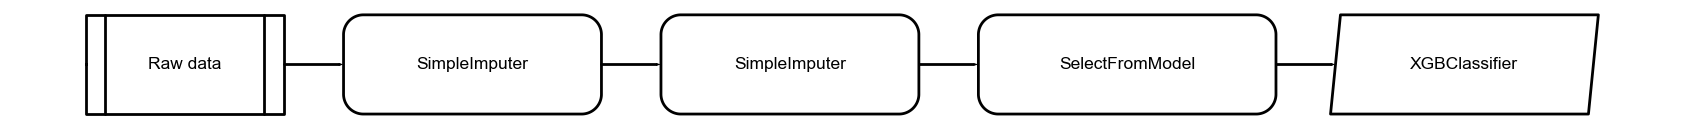

Creazione curva auc...


Errore durante la creazione della curva AUC: feature_names mismatch: ['feature_1', 'feature_3', 'feature_7', 'feature_8', 'feature_9', 'feature_11', 'feature_13', 'feature_14', 'feature_15', 'feature_17', 'feature_21', 'feature_24', 'feature_25', 'feature_26', 'feature_28', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_46', 'feature_47', 'feature_48', 'feature_51', 'feature_54', 'feature_63', 'feature_65', 'feature_73', 'feature_76', 'feature_77', 'feature_79', 'feature_86', 'feature_87', 'feature_89', 'feature_92', 'feature_93', 'feature_94', 'feature_107', 'feature_108', 'feature_109', 'feature_111', 'feature_112', 'feature_114', 'feature_119', 'feature_122', 'feature_123', 'feature_124', 'feature_127', 'feature_128', 'feature_129', 'feature_130', 'feature_132', 'feature_133'] ['feature_3', 'feature_5', 'feature_8', 'feature_9', 'feature_11', 'feature_13', 'feature_14', 'feature_15', 'feature_17', 'feature_21', 'feature_24', 'feature_25', 'feature_26'

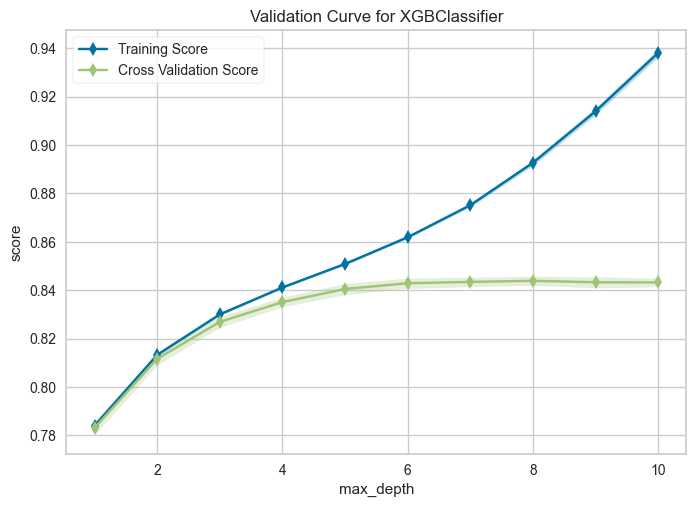

Creazione del report di classificazione del modello...


Errore durante la creazione del report di classificazione: feature_names mismatch: ['feature_1', 'feature_3', 'feature_7', 'feature_8', 'feature_9', 'feature_11', 'feature_13', 'feature_14', 'feature_15', 'feature_17', 'feature_21', 'feature_24', 'feature_25', 'feature_26', 'feature_28', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_46', 'feature_47', 'feature_48', 'feature_51', 'feature_54', 'feature_63', 'feature_65', 'feature_73', 'feature_76', 'feature_77', 'feature_79', 'feature_86', 'feature_87', 'feature_89', 'feature_92', 'feature_93', 'feature_94', 'feature_107', 'feature_108', 'feature_109', 'feature_111', 'feature_112', 'feature_114', 'feature_119', 'feature_122', 'feature_123', 'feature_124', 'feature_127', 'feature_128', 'feature_129', 'feature_130', 'feature_132', 'feature_133'] ['feature_3', 'feature_5', 'feature_8', 'feature_9', 'feature_11', 'feature_13', 'feature_14', 'feature_15', 'feature_17', 'feature_21', 'feature_24', 'feature_25'

Errore durante la creazione del grafico PR: feature_names mismatch: ['feature_1', 'feature_3', 'feature_7', 'feature_8', 'feature_9', 'feature_11', 'feature_13', 'feature_14', 'feature_15', 'feature_17', 'feature_21', 'feature_24', 'feature_25', 'feature_26', 'feature_28', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_46', 'feature_47', 'feature_48', 'feature_51', 'feature_54', 'feature_63', 'feature_65', 'feature_73', 'feature_76', 'feature_77', 'feature_79', 'feature_86', 'feature_87', 'feature_89', 'feature_92', 'feature_93', 'feature_94', 'feature_107', 'feature_108', 'feature_109', 'feature_111', 'feature_112', 'feature_114', 'feature_119', 'feature_122', 'feature_123', 'feature_124', 'feature_127', 'feature_128', 'feature_129', 'feature_130', 'feature_132', 'feature_133'] ['feature_3', 'feature_5', 'feature_8', 'feature_9', 'feature_11', 'feature_13', 'feature_14', 'feature_15', 'feature_17', 'feature_21', 'feature_24', 'feature_25', 'feature_26',

Errore durante la creazione del grafico di calibrazione: feature_names mismatch: ['feature_1', 'feature_3', 'feature_7', 'feature_8', 'feature_9', 'feature_11', 'feature_13', 'feature_14', 'feature_15', 'feature_17', 'feature_21', 'feature_24', 'feature_25', 'feature_26', 'feature_28', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_46', 'feature_47', 'feature_48', 'feature_51', 'feature_54', 'feature_63', 'feature_65', 'feature_73', 'feature_76', 'feature_77', 'feature_79', 'feature_86', 'feature_87', 'feature_89', 'feature_92', 'feature_93', 'feature_94', 'feature_107', 'feature_108', 'feature_109', 'feature_111', 'feature_112', 'feature_114', 'feature_119', 'feature_122', 'feature_123', 'feature_124', 'feature_127', 'feature_128', 'feature_129', 'feature_130', 'feature_132', 'feature_133'] ['feature_3', 'feature_5', 'feature_8', 'feature_9', 'feature_11', 'feature_13', 'feature_14', 'feature_15', 'feature_17', 'feature_21', 'feature_24', 'feature_25', 

<Figure size 800x550 with 0 Axes>

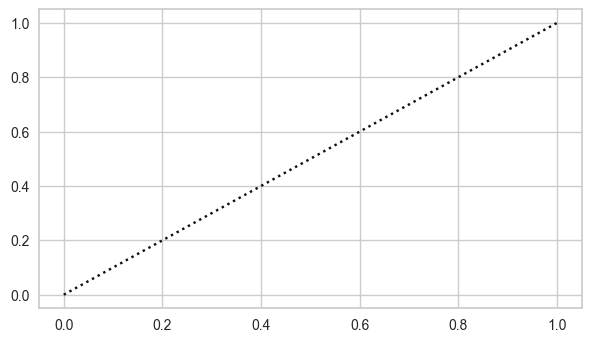

In [20]:
model_trainer = ModelTrainer(data=fit_data_with_features_df, labels=labels_clean_df)
model_trainer.search_and_train_single_model(model_search=True, n_sample_per_class=250000)

In [17]:
#load_model = load_model('best_binary_classification_model')


### Training dell'ensemble dei modelli migliori

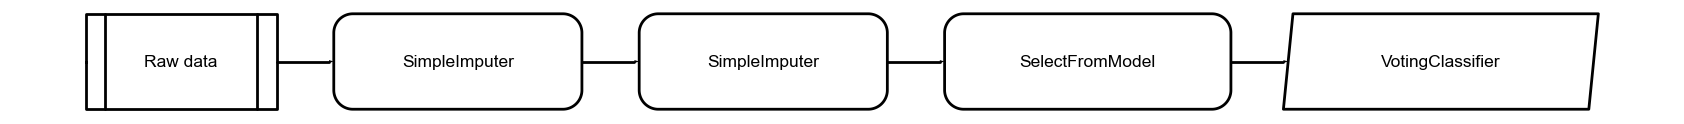

Creazione curva auc...


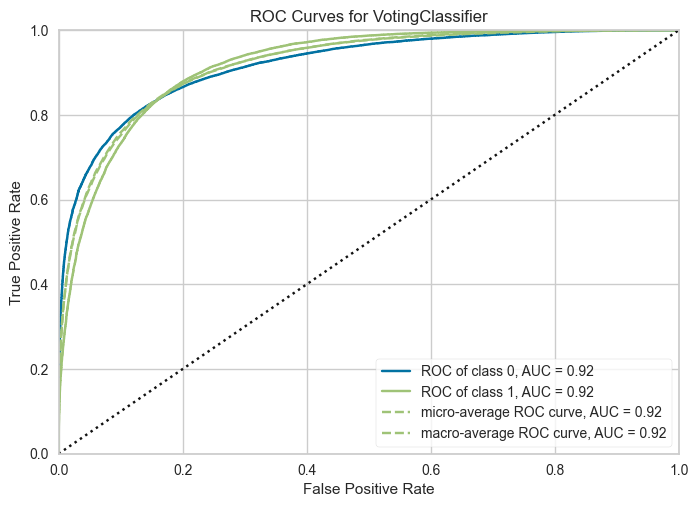

Creazione del grafico di vc...


Errore durante la creazione del grafico di VC: Plot not supported for this estimator. Try different estimator.
Creazione del report di classificazione del modello...


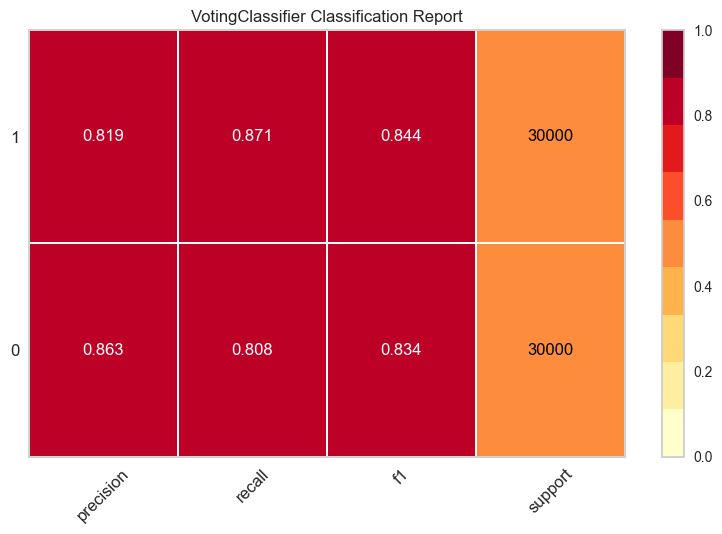

Creazione del grafico PR del modello...


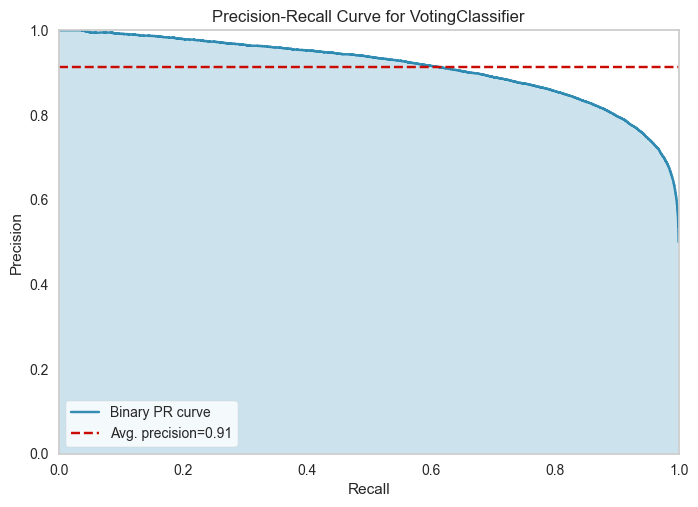

Calibrazione del modello...


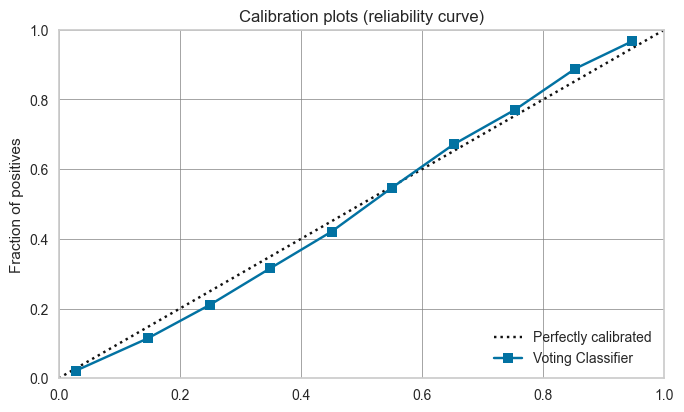

Transformation Pipeline and Model Successfully Saved


In [ ]:
model_trainer = ModelTrainer(data=features_df, labels=labels_df)
model_trainer.train_ensemble_model(n_sample_per_class=200000)